# Illustrating some gradient-based optimization issues

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D

In [193]:
X=np.linspace(0,1,1000)
Y=np.linspace(-1,1,1000)
points=[(x,y) for x in X for y in Y]

In [164]:
def f(x,y):
    return x/(1+y**2) + 3.5*x*(1-x)

In [145]:
def composee(x,y,times=1,f=f):
    for _ in range(times):
        x=f(x,y)
    return x

In [167]:
Z=[composee(x,y,2,f) for x in X for y in Y]

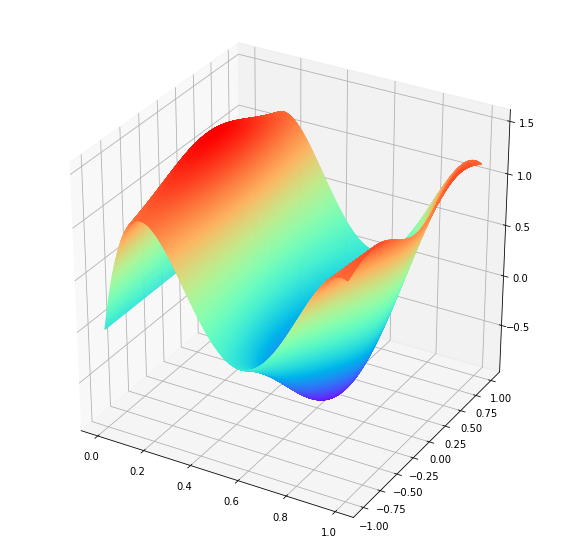

In [168]:
M,m=max(Z),min(Z)
colors=cm.rainbow([(z-m)/(M-m) for z in Z])
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([p[0] for p in points],[p[1] for p in points], Z, zdir='z', s=0.1, c=colors, depthshade=True)

This function has a global minimum on the input space we defined, not so easy to find analytically, but for the needs of the demonstration we will try to get it numerically. We remind the reader that :
$$\nabla f(f(x,y),y) = \nabla (f \circ h )(x,y) $$
Where $h(x,y) = (f(x,y) , y)$. We have therefore : 
$$ \nabla f(f(x,y),y) = \nabla h (x,y) . \nabla f (h(x,y)) $$
Let's first compute the gradient function of f :

In [171]:
def df_dx(x,y):
    return 1./(1+y**2) - 7*x + 3.5

def df_dy(x,y):
    return x*(-2*y/((1+y**2)**2))

In [172]:
def grad_f(x,y):
    return np.asarray([df_dx(x,y),df_dy(x,y)])

Then we can get the analytical expression of the gradient of our composite function :

In [184]:
def h(x,y):
    return np.asarray([f(x,y),y])

def grad_h(x,y):
    return np.vstack((grad_f(x,y),np.asarray([0,1])))

def grad_composee(x,y):
    return np.dot(grad_h(x,y),grad_f(f(x,y),y))

In [185]:
grad_Z=[np.linalg.norm(grad_composee(x,y)) for x in X for y in Y]

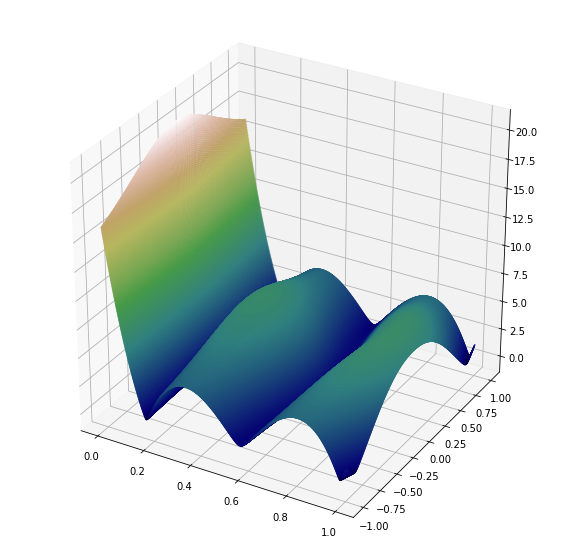

In [187]:
g_M,g_m=max(grad_Z),min(grad_Z)
g_colors=cm.gist_earth([(z-g_m)/(g_M-g_m) for z in grad_Z])
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([p[0] for p in points],[p[1] for p in points], grad_Z, zdir='z', s=0.1, c=g_colors, depthshade=True)

You can see that in some places, we have very high gradients (in amplitude), that could make us miss the minimum :

In [260]:
lr=5e-2
init=[0.18,0.1]
# init=[1,-0.5]
n_iter=5
g_points=[init]
while n_iter>0:
    point=g_points[-1]
    step=lr*grad_composee(point[0],point[1])
    point=[point[0] - step[0],point[1] - step[1]]
    g_points.append(point)
    n_iter-=1
g_points

[[0.18, 0.1],
 [0.24010203280102915, 0.10681127165750592],
 [0.4703401127057522, 0.11595782836551935],
 [0.759288791727802, 0.131041666475189],
 [0.5387842760256962, 0.1485980481746233],
 [0.7230601204532447, 0.1684681949694593]]

Let's plot our trajectory :

In [261]:
X_pos=[p[0] for p in g_points]
Y_pos=[p[1] for p in g_points]
Z_pos=[composee(p[0],p[1],2,f) for p in g_points]
X_dir=[j-i for i, j in zip(X_pos[:-1], X_pos[1:])]
Y_dir=[j-i for i, j in zip(Y_pos[:-1], Y_pos[1:])]
Z_dir=[j-i for i, j in zip(Z_pos[:-1], Z_pos[1:])]

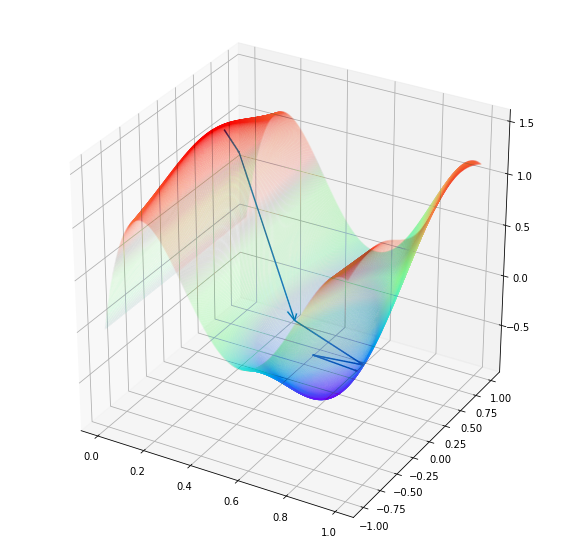

In [262]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([p[0] for p in points],[p[1] for p in points], Z, zdir='z', s=0.1, c=colors, alpha=0.02, depthshade=True)
ax.quiver(X_pos[:-1], Y_pos[:-1], Z_pos[:-1], X_dir, Y_dir, Z_dir, arrow_length_ratio=0.05, normalize=False)
# ax.view_init(-5)

Here, you can see that we went too far on the X axis on third update, and missed the minimum. This can be solved in two ways : smaller/decreasing learning rate, or gradient clipping.

## Decreasing the learning rate

In [267]:
lr_init=5e-2
init=[0.18,0.1]
# init=[1,-0.5]
n_iter=5
g_points=[init]
lr=lr_init
while n_iter>0:
    point=g_points[-1]
    step=lr*grad_composee(point[0],point[1])
    point=[point[0] - step[0],point[1] - step[1]]
    g_points.append(point)
    n_iter-=1
    lr=lr/1.5
g_points

[[0.18, 0.1],
 [0.24010203280102915, 0.10681127165750592],
 [0.3935940860708445, 0.11290897612951488],
 [0.5501585790661833, 0.11889761856768141],
 [0.6001030915081104, 0.12372287070846316],
 [0.6151422320187708, 0.1271154068848518]]

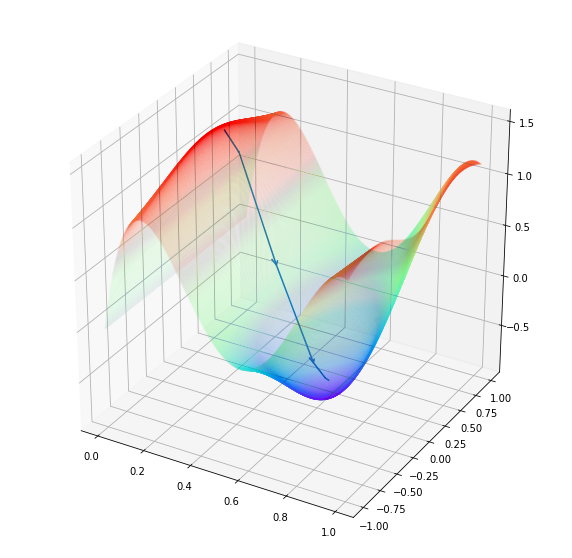

In [268]:
X_pos=[p[0] for p in g_points]
Y_pos=[p[1] for p in g_points]
Z_pos=[composee(p[0],p[1],2,f) for p in g_points]
X_dir=[j-i for i, j in zip(X_pos[:-1], X_pos[1:])]
Y_dir=[j-i for i, j in zip(Y_pos[:-1], Y_pos[1:])]
Z_dir=[j-i for i, j in zip(Z_pos[:-1], Z_pos[1:])]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([p[0] for p in points],[p[1] for p in points], Z, zdir='z', s=0.1, c=colors, alpha=0.02, depthshade=True)
ax.quiver(X_pos[:-1], Y_pos[:-1], Z_pos[:-1], X_dir, Y_dir, Z_dir, arrow_length_ratio=0.05, normalize=False)

## Gradient Clipping

### Norm Clipping

In [269]:
lr=5e-2
init=[0.18,0.1]
# init=[1,-0.5]
n_iter=5
g_points=[init]
max_norm=2
while n_iter>0:
    point=g_points[-1]
    gradient=grad_composee(point[0],point[1])
    if np.linalg.norm(gradient)>max_norm :
        gradient = max_norm/np.linalg.norm(gradient) * gradient
    step=lr*gradient
    point=[point[0] - step[0],point[1] - step[1]]
    g_points.append(point)
    n_iter-=1
g_points

[[0.18, 0.1],
 [0.24010203280102915, 0.10681127165750592],
 [0.34002321627702575, 0.11078079212680979],
 [0.43996441699928546, 0.11420955257236416],
 [0.5398638714391492, 0.11869274369226966],
 [0.6394888527536116, 0.12734509008460804]]

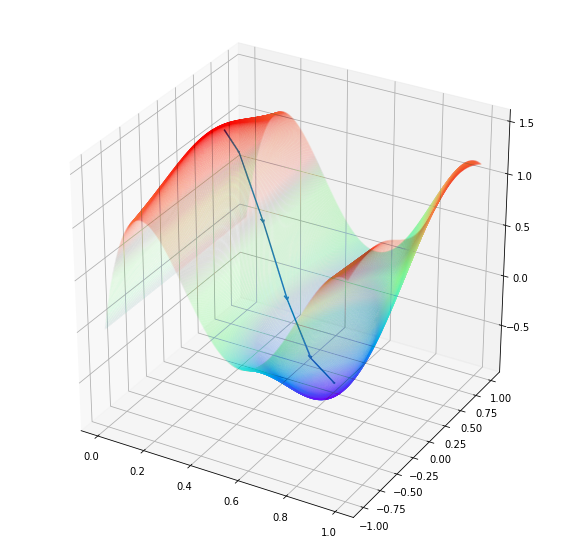

In [270]:
X_pos=[p[0] for p in g_points]
Y_pos=[p[1] for p in g_points]
Z_pos=[composee(p[0],p[1],2,f) for p in g_points]
X_dir=[j-i for i, j in zip(X_pos[:-1], X_pos[1:])]
Y_dir=[j-i for i, j in zip(Y_pos[:-1], Y_pos[1:])]
Z_dir=[j-i for i, j in zip(Z_pos[:-1], Z_pos[1:])]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([p[0] for p in points],[p[1] for p in points], Z, zdir='z', s=0.1, c=colors, alpha=0.02, depthshade=True)
ax.quiver(X_pos[:-1], Y_pos[:-1], Z_pos[:-1], X_dir, Y_dir, Z_dir, arrow_length_ratio=0.05, normalize=False)

### Component clipping

In [273]:
lr=5e-2
init=[0.18,0.1]
# init=[1,-0.5]
n_iter=5
g_points=[init]
max_comp=2
while n_iter>0:
    point=g_points[-1]
    gradient=grad_composee(point[0],point[1])
    np.clip(gradient,-max_comp,max_comp,out=gradient)
    step=lr*gradient
    point=[point[0] - step[0],point[1] - step[1]]
    g_points.append(point)
    n_iter-=1
g_points

[[0.18, 0.1],
 [0.24010203280102915, 0.10681127165750592],
 [0.34010203280102913, 0.11595782836551935],
 [0.4401020328010291, 0.1286152284956966],
 [0.5401020328010291, 0.14473801512249507],
 [0.6401020328010291, 0.16415595003904437]]

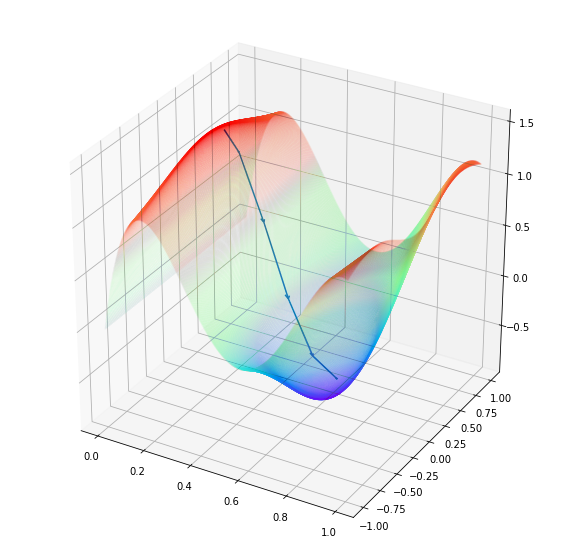

In [274]:
X_pos=[p[0] for p in g_points]
Y_pos=[p[1] for p in g_points]
Z_pos=[composee(p[0],p[1],2,f) for p in g_points]
X_dir=[j-i for i, j in zip(X_pos[:-1], X_pos[1:])]
Y_dir=[j-i for i, j in zip(Y_pos[:-1], Y_pos[1:])]
Z_dir=[j-i for i, j in zip(Z_pos[:-1], Z_pos[1:])]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([p[0] for p in points],[p[1] for p in points], Z, zdir='z', s=0.1, c=colors, alpha=0.02, depthshade=True)
ax.quiver(X_pos[:-1], Y_pos[:-1], Z_pos[:-1], X_dir, Y_dir, Z_dir, arrow_length_ratio=0.05, normalize=False)